In [1]:
import pickle
from functools import partial

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from chainconsumer import ChainConsumer
from tqdm import tqdm
import numpy as np
import h5py
import jax_cosmo as jc
import healpy as hp
from numpyro import distributions as dist
from jax.lib import xla_bridge
import numpyro
from numpyro import sample
from numpyro.handlers import condition, reparam, seed, trace

print(xla_bridge.get_backend().platform)

tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions

/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


gpu


In [2]:
lr_rate = 1e-2
total_steps = 50000
batch = 49999

PATH_experiment = f"{total_steps}_{lr_rate}_"

path =  f"./save_params/{PATH_experiment}/params_nd_vae_batch{batch}.pkl"
with open(path, "rb") as g:
    vae_params = pickle.load(g)
    
path = f"./save_params/{PATH_experiment}/opt_state_vae_batch{batch}.pkl"
with open(path, "rb") as g:
    opt_state = pickle.load(g)
    
path = f"./save_params/{PATH_experiment}/state_vae_batch{batch}.pkl"
with open(path, "rb") as g:
    state = pickle.load(g)

In [3]:
print("######## CONFIG ########")

sigma_e = 0.26
galaxy_density = gal_per_arcmin2 = 10 / 4
field_size = map_size = size = 10
field_npix = N = xsize = 80
nside = 512
reso = size * 60 / xsize
nbins = 1
dim = 6
nside = 512
mean_pixel_area = 4 * np.pi / hp.nside2npix(nside)
scaling_factor = 1 / mean_pixel_area

# Create our fiducial observations
pix_area = (map_size * 60 / N) ** 2  # arcmin2
map_size_rad = map_size / 180 * jnp.pi  # radians

######## CONFIG ########


In [4]:
print("######## OBSERVED DATA ########")

filename = '/gpfsdswork/dataset/CosmoGridV1/CosmoGridV1_metainfo.h5'
f = h5py.File(filename, "r")
dataset_grid = f['parameters']['fiducial']
cosmo_parameters = jnp.array([
            dataset_grid['Om'],
            dataset_grid['s8'],
            dataset_grid['w0'],
            dataset_grid['H0']/100,
            dataset_grid['ns'],
            dataset_grid['Ob']
        ]).T
truth = list(cosmo_parameters[0])
path = '/gpfsdswork/dataset/CosmoGridV1/stage3_forecast/fiducial/cosmo_fiducial/perm_0000/projected_probes_maps_baryonified512.h5'
m_data = h5py.File(path, "r")
m_data = np.array(m_data['kg']['stage3_lensing{}'.format(4)]) + np.array(m_data['ia']['stage3_lensing{}'.format(4)])
proj = hp.projector.GnomonicProj(rot=[0, 0, 0], xsize=xsize, ysize=xsize, reso=reso)
m_data = proj.projmap(m_data, vec2pix_func=partial(hp.vec2pix, nside))
m_data = dist.Independent(
            dist.Normal(
                m_data, 
                sigma_e / jnp.sqrt((galaxy_density * (field_size * 60 / field_npix) ** 2))
            ),
            2
        ).sample(jax.random.PRNGKey(0),(1,))

params_name = [r'$\Omega_m$',r'$\sigma_8$',r'$w_0$',r'$h_0$',r'$n_s$', r'$\Omega_b$']

######## OBSERVED DATA ########


In [5]:
Om_sample = tfd.Uniform(0.1,0.5).sample(1000, jax.random.PRNGKey(0))
s8_sample  = tfd.Uniform(0.4,1.4).sample(1000, jax.random.PRNGKey(10))
h_sample = tfd.Uniform(0.64, 0.82).sample(1000, jax.random.PRNGKey(20))
Ob_sample  = tfd.Uniform(0.03,0.06).sample(1000, jax.random.PRNGKey(30))
ns_sample  = tfd.Uniform(0.87, 1.07).sample(1000, jax.random.PRNGKey(40))
w0_sample  = tfd.Uniform(-2.0, -0.333).sample(1000, jax.random.PRNGKey(50))

prior = jnp.array([Om_sample, s8_sample, w0_sample, h_sample, ns_sample, Ob_sample]).T

In [6]:
print("######## CREATE VAE ########")
from unet_model import UResNet
import haiku as hk
from collections.abc import Mapping

# Unet from Benjamin Remy
class UResNet18(UResNet):
    """ResNet18."""

    def __init__(
        self,
        bn_config: Mapping[str, float] | None = None,
        use_bn: bool = None,
        pad_crop: bool = False,
        n_output_channels: int = 1,
        name: str | None = None,
    ):
        """Constructs a ResNet model.
        Args:
          bn_config: A dictionary of two elements, ``decay_rate`` and ``eps`` to be
            passed on to the :class:`~haiku.BatchNorm` layers.
          resnet_v2: Whether to use the v1 or v2 ResNet implementation. Defaults
            to ``False``.
          use_bn: Whether the network should use batch normalisation. Defaults to
            ``True``.
          n_output_channels: The number of output channels, for example to change in
            the case of a complex denoising. Defaults to 1.
          name: Name of the module.
        """
        super().__init__(
            blocks_per_group=(2, 2, 2),
            bn_config=bn_config,
            bottleneck=False,
            channels_per_group=(4, 8, 16),  # (32, 64, 128, 128),#//2,
            use_projection=(True, True, True),
            # 320 -> 160 -> 80 -> 40
            # 360 -> 180 -> 90 -> 45
            strides=(2, 2, 1),
            use_bn=use_bn,
            pad_crop=pad_crop,
            n_output_channels=n_output_channels,
            name=name,
        )

decoder_eval = hk.without_apply_rng(
    hk.transform_with_state(
        lambda z: UResNet18(n_output_channels=1, name="decoder")(
            z.reshape([-1, N, N, 1]), condition=None, is_training=False
        )
    )
)

######## CREATE VAE ########


In [7]:
from jax_cosmo.redshift import redshift_distribution
# class smail_nz(redshift_distribution):
#     def pz_fn(self, z):
#         a, b, z0 = self.params
#         return z**a * np.exp(-((z / z0) ** b)) * 4
    
def Pk_fn(k, cosmo, a_ai=None):
    pz = jc.redshift.smail_nz(3.53, 4.49, 1.03, gals_per_arcmin2=10 / 4)
    tracer = jc.probes.WeakLensing([pz], ia_bias=a_ai)
    ell_tab = jnp.logspace(0, 4.5, 128)
    cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer])[0]
    return jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)


def make_power_map(pk_fn, N, field_size, zero_freq_val=0.0):
    k = 2 * jnp.pi * jnp.fft.fftfreq(N, d=field_size / N)
    kcoords = jnp.meshgrid(k, k)
    k = jnp.sqrt(kcoords[0] ** 2 + kcoords[1] ** 2)
    ps_map = pk_fn(k)
    ps_map = ps_map.at[0, 0].set(zero_freq_val)
    return ps_map * (N / field_size) ** 2

def learned_forward_model():
    theta = numpyro.sample(
        "theta",
        dist.Independent(dist.Normal(jnp.array([0.3, 0.8]), 0.05 * jnp.ones(2)), 1),
    )

    Om = numpyro.sample("Om", dist.Uniform(0.1,0.5))
    s8 = numpyro.sample("s8", dist.Uniform(0.4,1.4))
    h = numpyro.sample("h", dist.Uniform(0.64, 0.82))
    Ob = numpyro.sample("Ob", dist.Uniform(0.03,0.06))
    ns = numpyro.sample("ns", dist.Uniform(0.87, 1.07))
    w0 = numpyro.sample("w0", dist.Uniform(-2.0, -0.333))
    
    z = numpyro.sample(
        "z", dist.MultivariateNormal(loc=jnp.zeros((N, N)), precision_matrix=jnp.eye(N))
    )
    
    cosmo = jc.Planck15(
        Omega_c=Om - Ob,
        Omega_b=Ob,
        h=h,
        n_s=ns,
        sigma8=s8,
        Omega_k=0.0,
        w0=w0,
        wa=0.0,
    )
    
    P = partial(Pk_fn, cosmo=cosmo, a_ai=None)
    power_map = make_power_map(P, N, map_size_rad)
    
    gaussian_map = jnp.fft.ifft2(jnp.fft.fft2(z) * jnp.sqrt(power_map)).real

    out_vae, _ = decoder_eval.apply(vae_params, state[1], gaussian_map)
    
    x = numpyro.sample(
        "x",
        dist.Independent(
            dist.Normal(out_vae.squeeze(), sigma_e / jnp.sqrt(gal_per_arcmin2 * pix_area)), 2
        ),
    )
    
    return x

In [8]:
fiducial_model = numpyro.handlers.condition(
    learned_forward_model, 
    {
        "Om": cosmo_parameters[0][0], 
        "s8": cosmo_parameters[0][1], 
        "w0": cosmo_parameters[0][2], 
        "h": cosmo_parameters[0][3], 
        "ns": cosmo_parameters[0][4],
        "Ob": cosmo_parameters[0][5], 
    }
)

model_trace = numpyro.handlers.trace(seed(fiducial_model, jax.random.PRNGKey(1234))).get_trace()

init_values = {
    k: model_trace[k]["value"] for k in ["z", "Om", "s8", "w0", "h", "ns", "Ob"]
}


######### RUN FULL-FIELD MCMC ##########
num_samples = 3000
num_chains = 1
thinning = 5
num_warmup = 300
chain_method = "vectorized"
step_size = 1e-2
max_tree_depth = 4

observed_model = condition(
    learned_forward_model,
    {"x":m_data},
)

# Building the sampling kernel
nuts_kernel = numpyro.infer.NUTS(
    model=observed_model,
    init_strategy=numpyro.infer.init_to_value(values=init_values), # initial conditions do not corresponds to the true ones!
    max_tree_depth=max_tree_depth,
    step_size=step_size,
)

mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=num_warmup,
    num_samples=num_samples,
    num_chains=num_chains,
    chain_method=chain_method,
    thinning=thinning,
    progress_bar=True,
)

mcmc.run(jax.random.PRNGKey(0), extra_fields=("num_steps",))
samples_ = mcmc.get_samples()
# save only sample of interest
samples_ = jnp.stack(
    [
        samples_['Om'],
        samples_['s8'],
        samples_['w0'],
        samples_['h'],
        samples_['ns'],
        samples_['Ob']
    ],
    axis=-1,
)

/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/linkhome/rech/genkqu01/uf

In [14]:
jnp.save('chains', samples_)

In [ ]:
params_name = [r'$\Omega_m$',r'$\sigma_8$',r'$w_0$',r'$h_0$',r'$n_s$', r'$\Omega_b$']

for i in range(6):
    plt.plot(samples_[:, i], alpha=0.3)
    plt.title(params_name[i])
    plt.show()

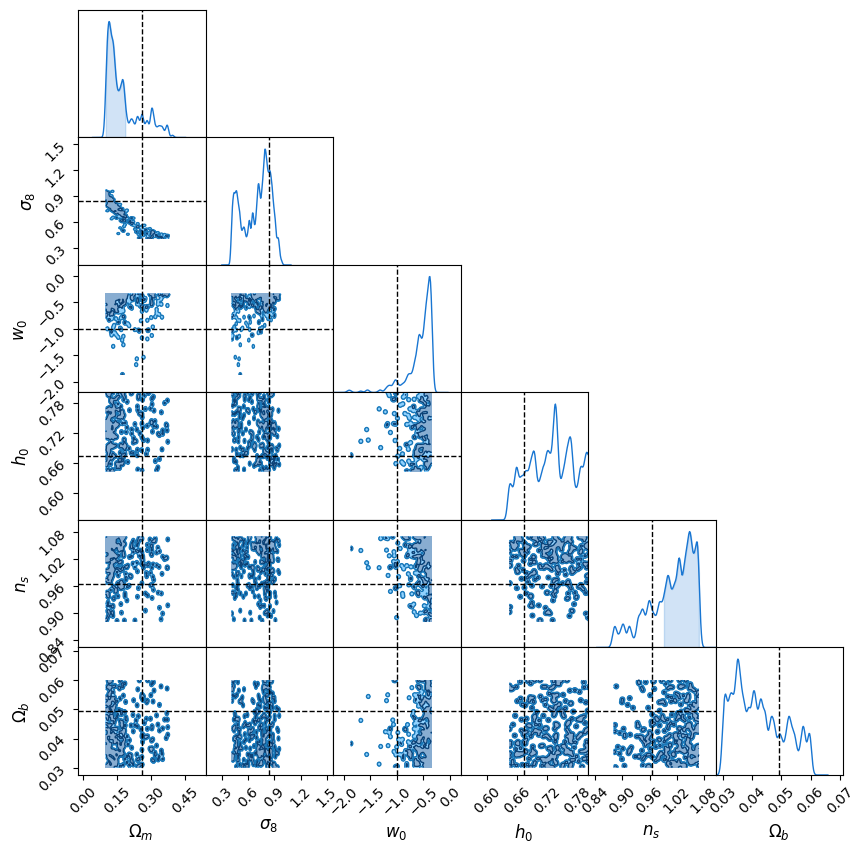

In [11]:
from chainconsumer import ChainConsumer

params_name = [r'$\Omega_m$',r'$\sigma_8$',r'$w_0$',r'$h_0$',r'$n_s$', r'$\Omega_b$']
c = ChainConsumer()

c.add_chain(
    samples_,
    shade_alpha = 0.5, 
    parameters = params_name, 
    name = f'learned model'
)

fig = c.plotter.plot(
    figsize=1.,
    truth=truth,
    extents=[[t - 2.5 * np.std(prior[:,i]),
              t + 2.5 * np.std(prior[:,i])] for i,t in enumerate(truth)]
)

In [12]:
posterior_vmim_gaussian = jnp.load('/gpfsdswork/projects/rech/eqw/ufa23yn/dev/PoCLikelihoodInference/sbi/nde_notebooks/posterior_vmim_gaussian.npy')
posterior_vmim_nbody_with_baryon_ia = jnp.load('/gpfsdswork/projects/rech/eqw/ufa23yn/dev/PoCLikelihoodInference/sbi/nde_notebooks/posterior_vmim_nbody_with_baryon_ia.npy')

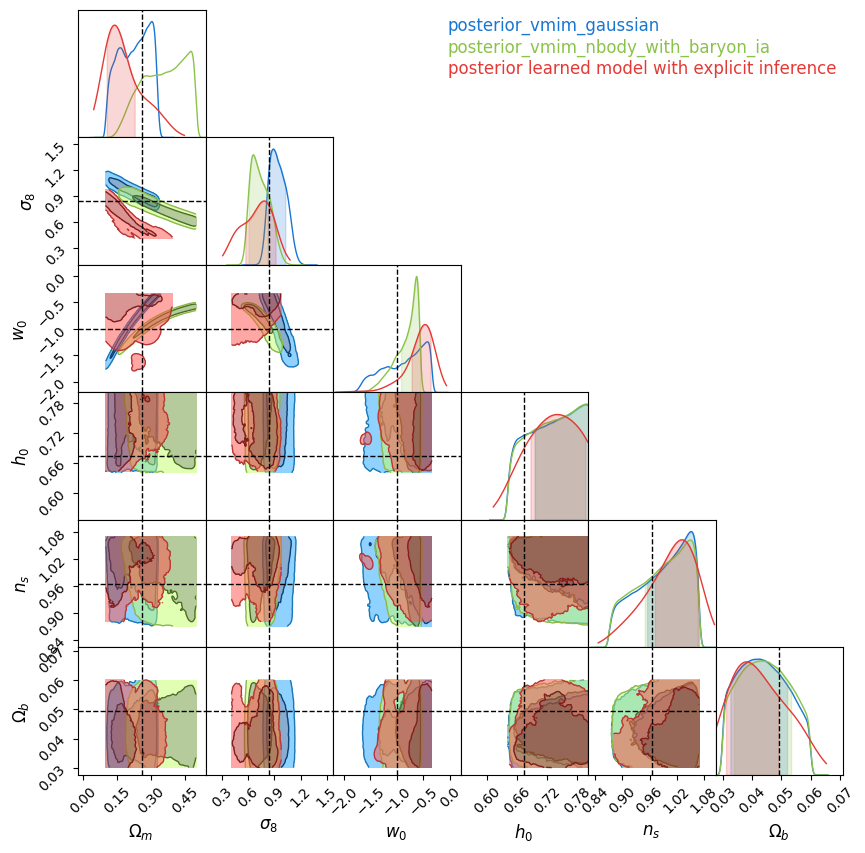

In [15]:
c = ChainConsumer()

c.add_chain(
    posterior_vmim_gaussian,
    shade_alpha = 0.5,
    parameters = params_name,
    name = 'posterior_vmim_gaussian',
)

c.add_chain(
    posterior_vmim_nbody_with_baryon_ia,
    shade_alpha = 0.5,
    parameters = params_name, 
    name = 'posterior_vmim_nbody_with_baryon_ia'
)

c.add_chain(
    samples_,
    shade_alpha = 0.5,
    parameters = params_name,
    name = 'posterior learned model with explicit inference', 
    kde = 1
)

fig = c.plotter.plot(
    figsize=1.,
    truth=truth,
    extents=[[t - 2.5 * np.std(prior[:,i]),
              t + 2.5 * np.std(prior[:,i])] for i,t in enumerate(truth)]
)